In [1]:
!pip install prophet plotly streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 64.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Walmart_Sales.csv')

# Basic exploration
print("Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn names:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nBasic statistics:\n", df.describe())

Shape: (6435, 8)

First 5 rows:
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  

Column names: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

Data types:
 Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dt

In [4]:
# Convert date column
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Sort by date
df = df.sort_values('Date')

# Check unique stores
print(f"Total Stores: {df['Store'].nunique()}")
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total Records: {len(df)}")

# Aggregate total weekly sales across all stores
df_total = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
df_total.columns = ['Date', 'Total_Weekly_Sales']

print("\n✅ Data cleaned successfully!")
print(df_total.head(10))

Total Stores: 45
Date Range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Total Records: 6435

✅ Data cleaned successfully!
        Date  Total_Weekly_Sales
0 2010-02-05         49750740.50
1 2010-02-12         48336677.63
2 2010-02-19         48276993.78
3 2010-02-26         43968571.13
4 2010-03-05         46871470.30
5 2010-03-12         45925396.51
6 2010-03-19         44988974.64
7 2010-03-26         44133961.05
8 2010-04-02         50423831.26
9 2010-04-09         47365290.44


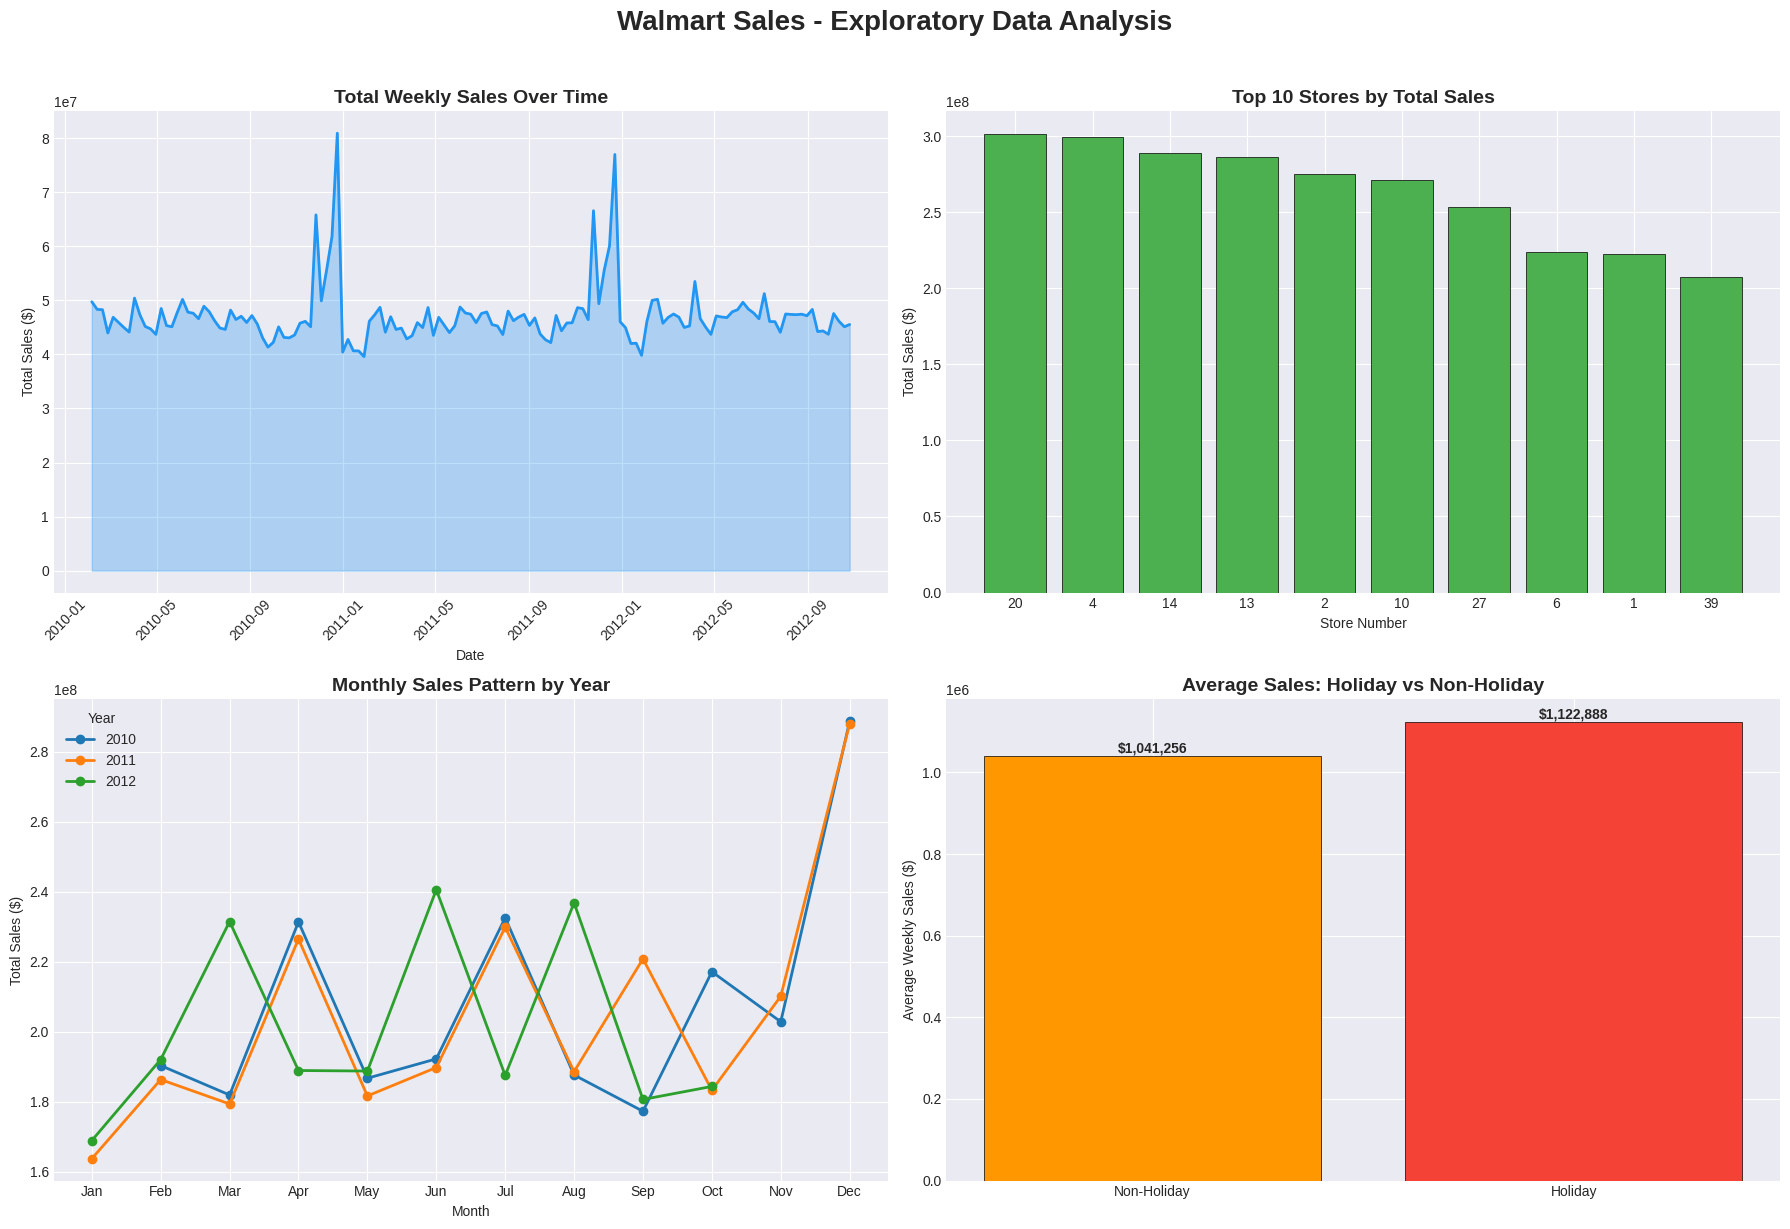

✅ EDA plots saved as 'walmart_eda.png'


In [5]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Walmart Sales - Exploratory Data Analysis',
             fontsize=20, fontweight='bold', y=1.02)

# Plot 1 - Total Weekly Sales Over Time
axes[0,0].plot(df_total['Date'], df_total['Total_Weekly_Sales'],
               color='#2196F3', linewidth=2)
axes[0,0].fill_between(df_total['Date'], df_total['Total_Weekly_Sales'],
                        alpha=0.3, color='#2196F3')
axes[0,0].set_title('Total Weekly Sales Over Time', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Total Sales ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2 - Sales by Store (Top 10)
store_sales = df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(10)
axes[0,1].bar(store_sales.index.astype(str), store_sales.values,
              color='#4CAF50', edgecolor='black', linewidth=0.5)
axes[0,1].set_title('Top 10 Stores by Total Sales', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Store Number')
axes[0,1].set_ylabel('Total Sales ($)')

# Plot 3 - Monthly Sales Pattern
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
monthly_sales = df.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()
monthly_pivot = monthly_sales.pivot(index='Month', columns='Year', values='Weekly_Sales')
monthly_pivot.plot(ax=axes[1,0], marker='o', linewidth=2)
axes[1,0].set_title('Monthly Sales Pattern by Year', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Total Sales ($)')
axes[1,0].set_xticks(range(1,13))
axes[1,0].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                            'Jul','Aug','Sep','Oct','Nov','Dec'])

# Plot 4 - Holiday vs Non-Holiday Sales
holiday_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].mean()
bars = axes[1,1].bar(['Non-Holiday', 'Holiday'], holiday_sales.values,
                      color=['#FF9800', '#F44336'], edgecolor='black', linewidth=0.5)
axes[1,1].set_title('Average Sales: Holiday vs Non-Holiday',
                     fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Average Weekly Sales ($)')
for bar, val in zip(bars, holiday_sales.values):
    axes[1,1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1000,
                   f'${val:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('walmart_eda.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ EDA plots saved as 'walmart_eda.png'")

In [6]:
# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_df = df_total.rename(columns={'Date': 'ds', 'Total_Weekly_Sales': 'y'})

# Split into train and test
train_size = int(len(prophet_df) * 0.8)
train_df = prophet_df[:train_size]
test_df = prophet_df[train_size:]

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

# Build and train Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)

# Add holiday seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Fit model
model.fit(train_df)
print("\n✅ Prophet model trained successfully!")

Training samples: 114
Testing samples: 29

✅ Prophet model trained successfully!


In [11]:
# Make future dataframe for predictions (52 weeks = 1 year ahead)
future = model.make_future_dataframe(periods=52, freq='W')
forecast = model.predict(future)

# FIX - Normalize dates before matching
forecast['ds'] = pd.to_datetime(forecast['ds']).dt.normalize()
test_df_fixed = test_df.copy()
test_df_fixed['ds'] = pd.to_datetime(test_df_fixed['ds']).dt.normalize()

# Merge on normalized dates
merged = pd.merge(test_df_fixed[['ds', 'y']],
                  forecast[['ds', 'yhat']],
                  on='ds',
                  how='inner')

print(f"Matched test samples: {len(merged)}")

# Check if merge worked
if len(merged) == 0:
    # Fallback - use last N predictions from forecast
    n_test = len(test_df)
    test_preds = forecast['yhat'].iloc[train_size:train_size + n_test].values
    test_actual_vals = test_df['y'].values
else:
    test_preds = merged['yhat'].values
    test_actual_vals = merged['y'].values

# Calculate metrics
mae = mean_absolute_error(test_actual_vals, test_preds)
rmse = np.sqrt(mean_squared_error(test_actual_vals, test_preds))
mape = np.mean(np.abs((test_actual_vals - test_preds) / test_actual_vals)) * 100

print("=" * 50)
print("📊 MODEL PERFORMANCE METRICS")
print("=" * 50)
print(f"MAE  (Mean Absolute Error):      ${mae:,.2f}")
print(f"RMSE (Root Mean Squared Error):  ${rmse:,.2f}")
print(f"MAPE (Mean Absolute % Error):    {mape:.2f}%")
print(f"Accuracy:                        {100-mape:.2f}%")
print("=" * 50)

Matched test samples: 0
📊 MODEL PERFORMANCE METRICS
MAE  (Mean Absolute Error):      $4,874,342.44
RMSE (Root Mean Squared Error):  $5,332,092.91
MAPE (Mean Absolute % Error):    10.55%
Accuracy:                        89.45%


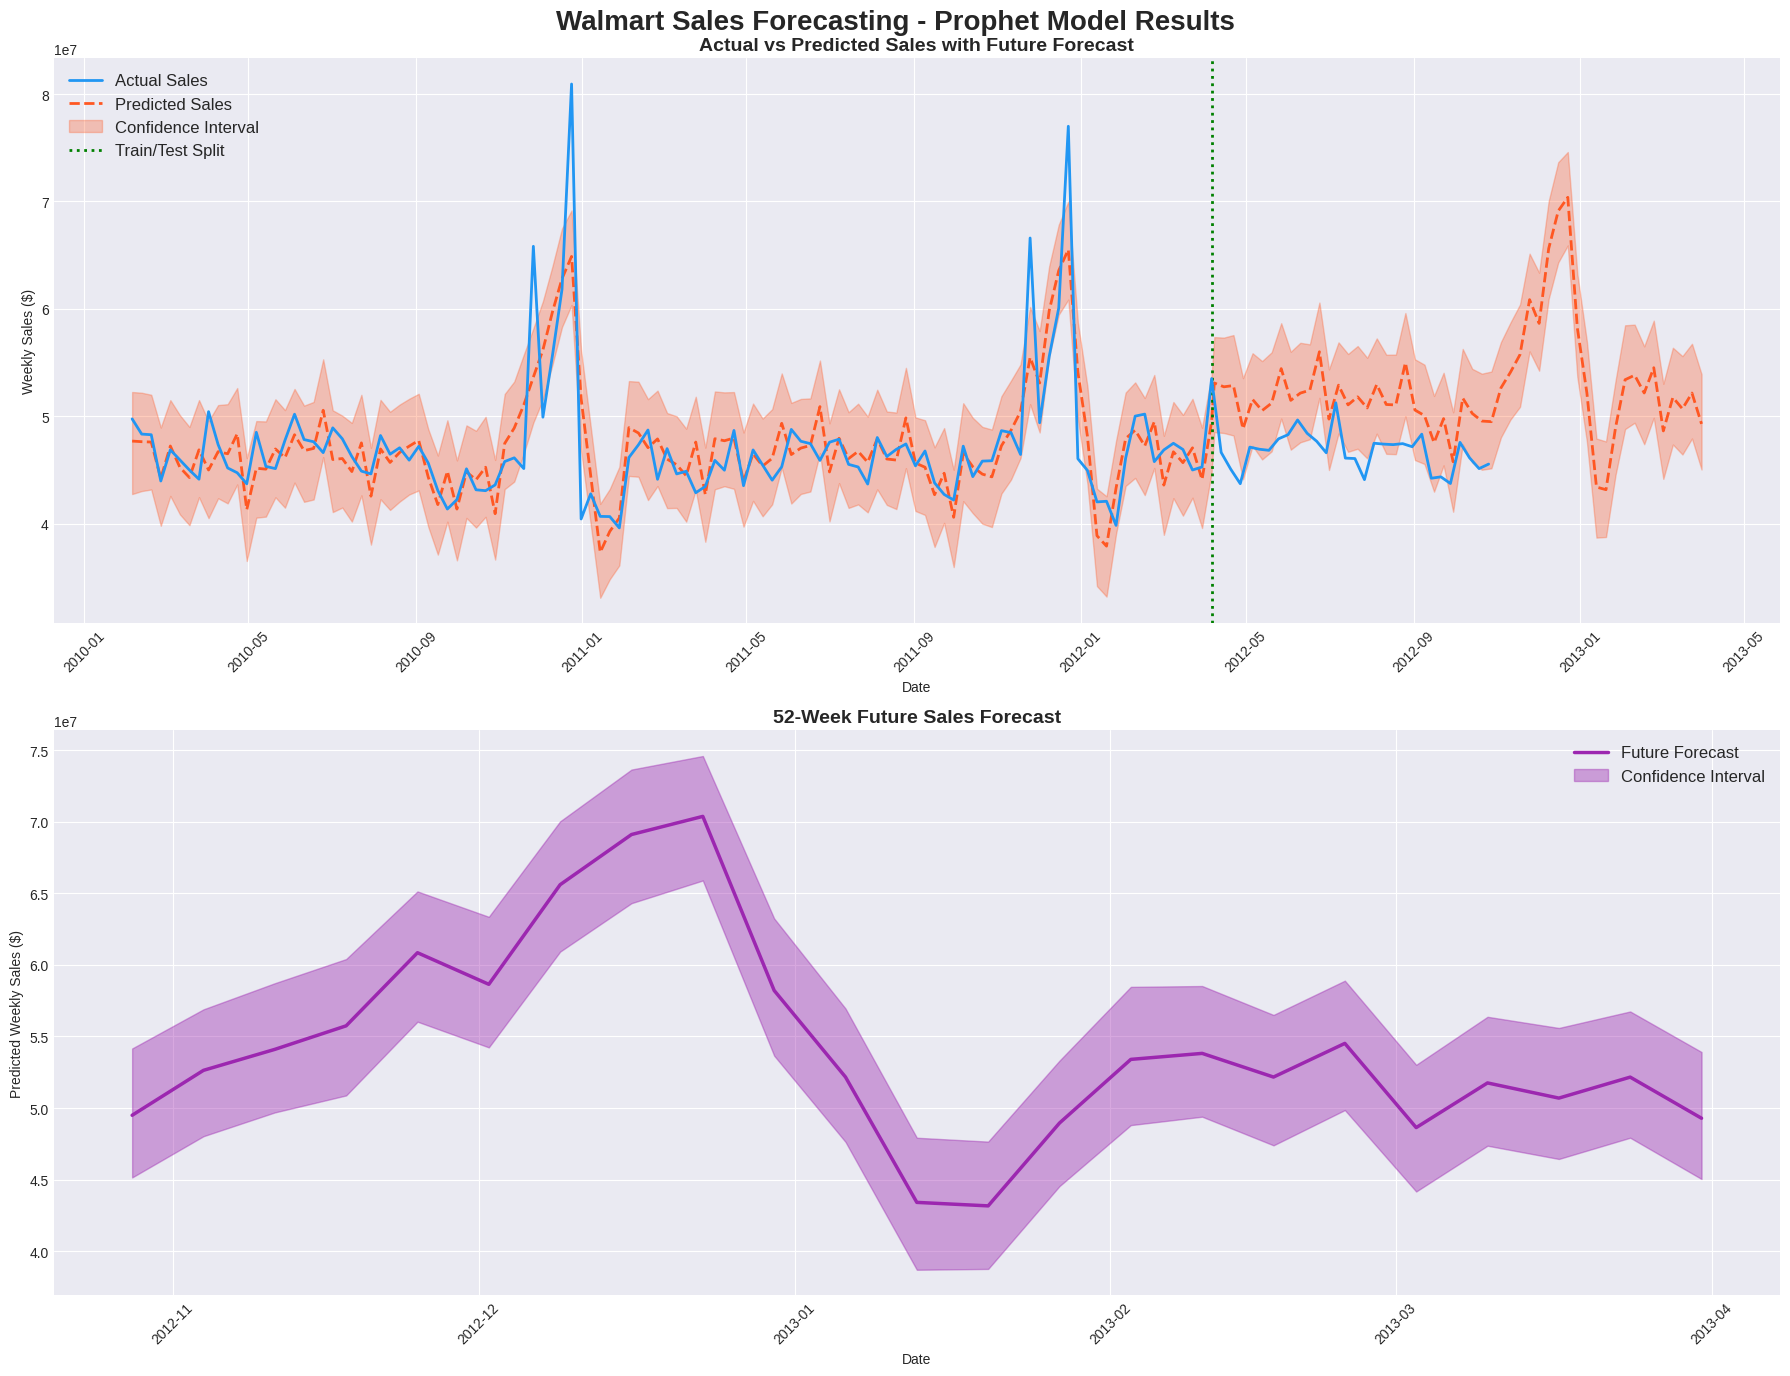

✅ Forecast plot saved as 'walmart_forecast.png'


In [12]:
fig, axes = plt.subplots(2, 1, figsize=(18, 14))
fig.suptitle('Walmart Sales Forecasting - Prophet Model Results',
             fontsize=20, fontweight='bold')

# Plot 1 - Full Forecast
axes[0].plot(prophet_df['ds'], prophet_df['y'],
             color='#2196F3', linewidth=2, label='Actual Sales', zorder=5)
axes[0].plot(forecast['ds'], forecast['yhat'],
             color='#FF5722', linewidth=2, linestyle='--', label='Predicted Sales')
axes[0].fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                     alpha=0.3, color='#FF5722', label='Confidence Interval')
axes[0].axvline(x=train_df['ds'].max(), color='green',
                linestyle=':', linewidth=2, label='Train/Test Split')
axes[0].set_title('Actual vs Predicted Sales with Future Forecast',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Weekly Sales ($)')
axes[0].legend(fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2 - Forecast Components
future_only = forecast[forecast['ds'] > prophet_df['ds'].max()]
axes[1].plot(future_only['ds'], future_only['yhat'],
             color='#9C27B0', linewidth=2.5, label='Future Forecast')
axes[1].fill_between(future_only['ds'], future_only['yhat_lower'],
                     future_only['yhat_upper'],
                     alpha=0.4, color='#9C27B0', label='Confidence Interval')
axes[1].set_title('52-Week Future Sales Forecast', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Predicted Weekly Sales ($)')
axes[1].legend(fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('walmart_forecast.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Forecast plot saved as 'walmart_forecast.png'")

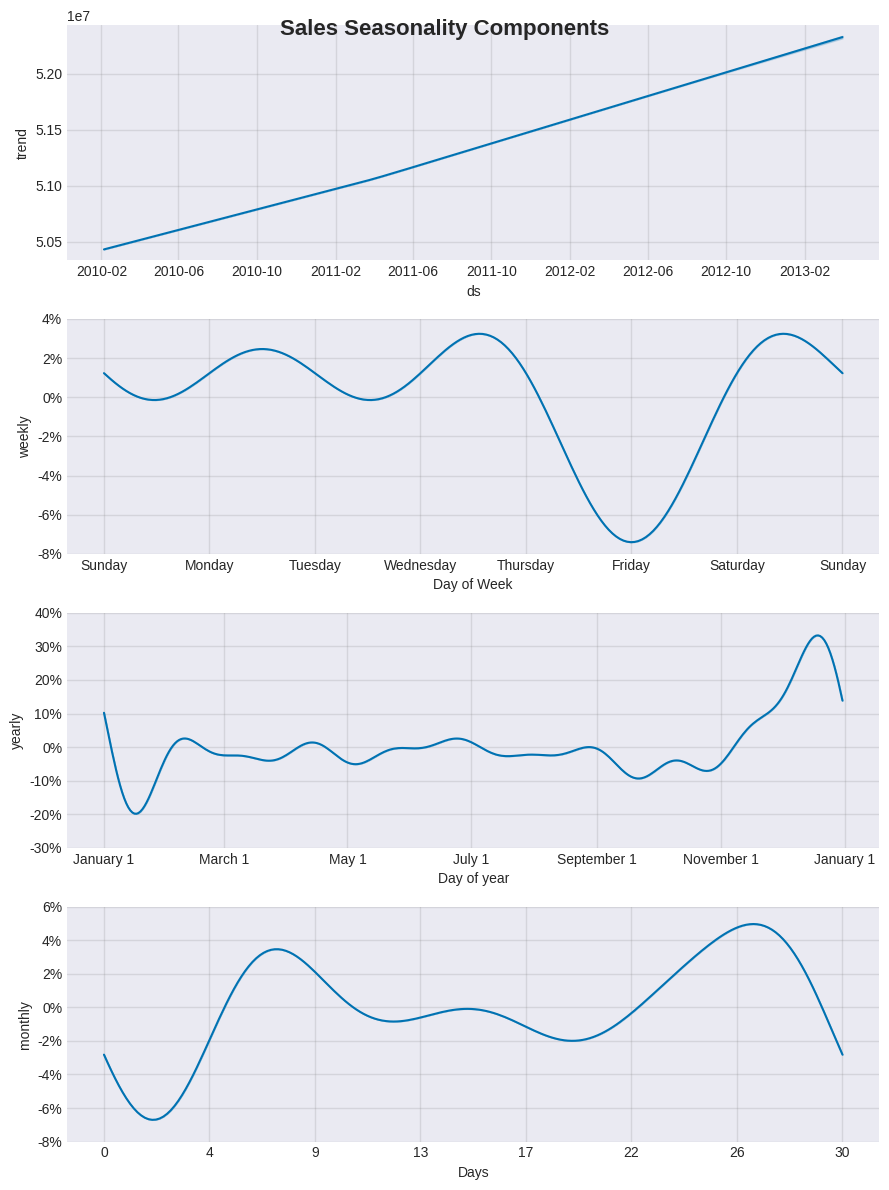

✅ Seasonality plot saved!


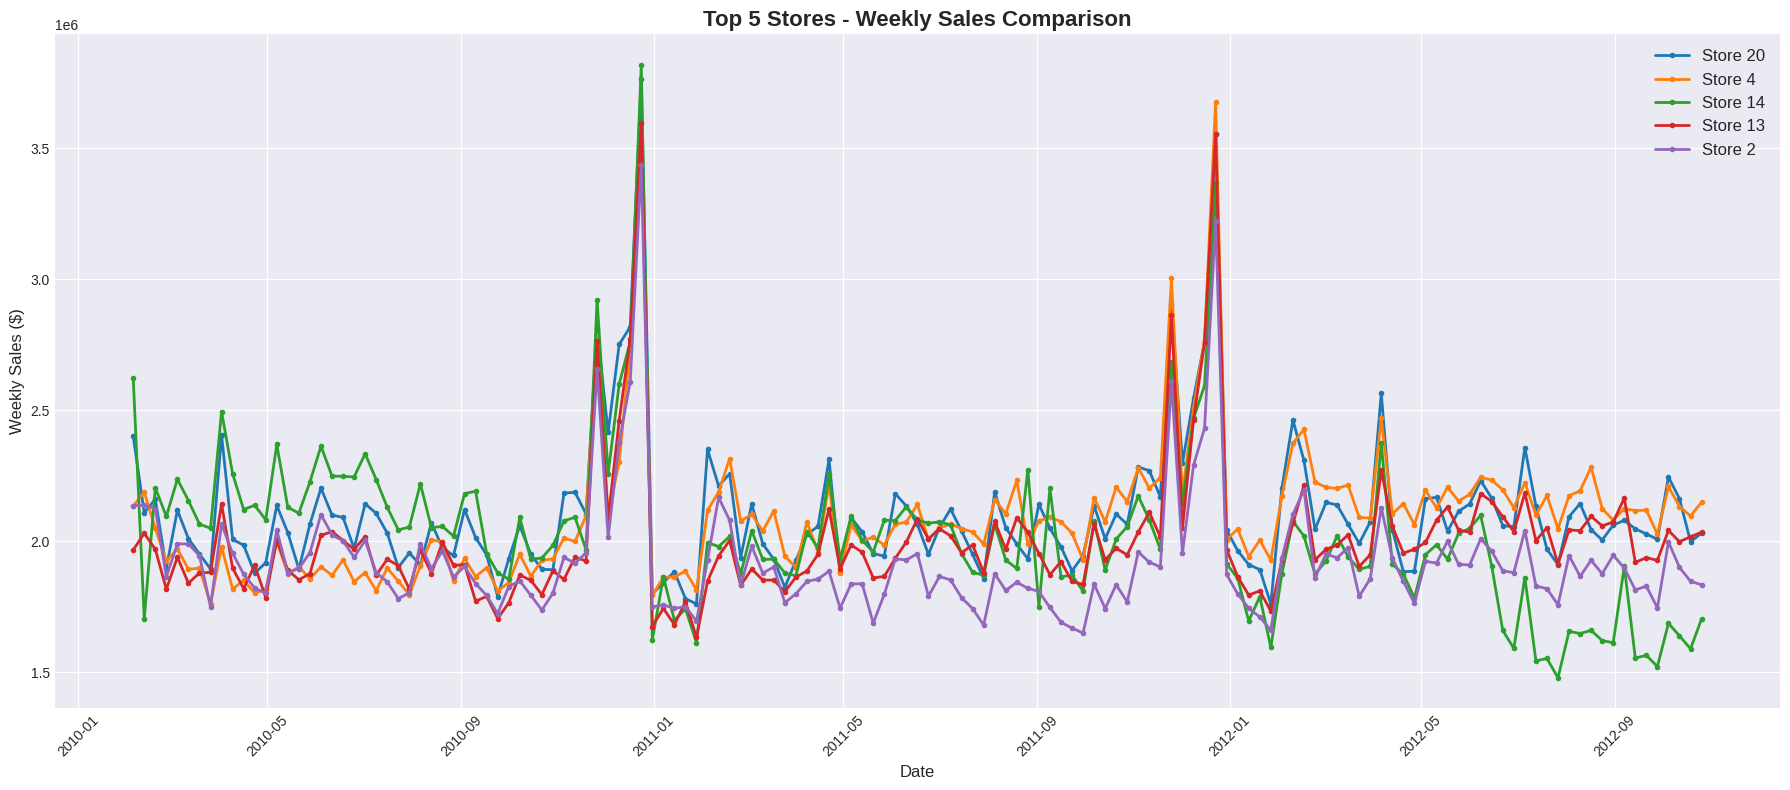

✅ Store comparison plot saved!


In [13]:
# Plot seasonality components
fig2 = model.plot_components(forecast)
fig2.suptitle('Sales Seasonality Components', fontsize=16, fontweight='bold')
plt.savefig('walmart_seasonality.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Seasonality plot saved!")

# Store-level analysis
fig3, ax = plt.subplots(figsize=(18, 8))
top5_stores = df.groupby('Store')['Weekly_Sales'].sum().nlargest(5).index
for store in top5_stores:
    store_data = df[df['Store']==store].groupby('Date')['Weekly_Sales'].sum()
    ax.plot(store_data.index, store_data.values,
            linewidth=2, label=f'Store {store}', marker='o', markersize=3)

ax.set_title('Top 5 Stores - Weekly Sales Comparison', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Weekly Sales ($)', fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('walmart_stores_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Store comparison plot saved!")

In [14]:
# Save forecast results to CSV
forecast_output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(52)
forecast_output.columns = ['Date', 'Predicted_Sales', 'Lower_Bound', 'Upper_Bound']
forecast_output.to_csv('walmart_forecast_results.csv', index=False)

print("=" * 60)
print("🎉 PROJECT COMPLETE! Files saved:")
print("=" * 60)
print("📊 walmart_eda.png              - EDA visualizations")
print("📈 walmart_forecast.png         - Forecast results")
print("🔄 walmart_seasonality.png      - Seasonality analysis")
print("🏪 walmart_stores_comparison.png - Store comparison")
print("💾 walmart_forecast_results.csv - Forecast data")
print("=" * 60)
print(f"\n🎯 Model Accuracy: {100-mape:.2f}%")
print(f"📅 Forecasted {len(forecast_output)} weeks ahead")
print("\n✅ Ready for Fiverr portfolio!")

🎉 PROJECT COMPLETE! Files saved:
📊 walmart_eda.png              - EDA visualizations
📈 walmart_forecast.png         - Forecast results
🔄 walmart_seasonality.png      - Seasonality analysis
🏪 walmart_stores_comparison.png - Store comparison
💾 walmart_forecast_results.csv - Forecast data

🎯 Model Accuracy: 89.45%
📅 Forecasted 52 weeks ahead

✅ Ready for Fiverr portfolio!
